In [1]:
### 필요한 모듈 IMPORT
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

In [2]:
################################################
#####BASE MODEL 확인을 위한 간단한 전처리#########
################################################

# 파일 읽어오기
a=pd.read_csv(r"C:\Users\moonp\ASAC과정\ASAC_ml_project\web_crawling\merge_dataset\raw_merge.csv",sep="\t")
### METACRITIC 점수 표기 --> 메타크리틱 점수가 없는 경우 -1로 대체
a.metacritic=a.metacritic.fillna(-1)
tmp=a.dropna(axis=0)
### 동접자수 전처리 과정 동접자수 없는 경우 0으로 표기
tmp["24_Hour_Peak"].replace("Invalid","0",inplace=True)
tmp["All_time_peak"].replace("Invalid","0",inplace=True)
tmp["24_Hour_Peak"]=tmp["24_Hour_Peak"].astype(int)
tmp["All_time_peak"]=tmp["All_time_peak"].astype(int)

### is free 전처리 기존의 FALSE,TRUE --> 0,1로 바꾸어서
tmp.is_free.replace("False","0",inplace=True)
tmp.is_free.replace("0.0","0",inplace=True)
tmp.is_free.replace("True","1",inplace=True)
tmp.is_free.replace("1.0","1",inplace=True)
tmp.is_free=tmp.is_free.astype(int)
tmp.is_free=tmp.is_free.astype(int)


### TARGET CLASS를 4개로 재분류
No_interest_lst=['No user reviews','8 user reviews','7 user reviews','4 user reviews','9 user reviews','5 user reviews','6 user reviews','2 user reviews','3 user reviews','1 user reviews','None']
Positive_lst=['Overwhelmingly Positive','Very Positive','Positive','Mostly Positive']
Negative_lst=['Negative','Very Negative','Overwhelmingly Negative','Mostly Negative']
tmp.Review.replace(No_interest_lst,"No_interest",inplace=True)
tmp.Review.replace(Positive_lst,"Positive",inplace=True)
tmp.Review.replace(Negative_lst,"Negative",inplace=True)

### TARGET LABEL ENCODING
le=preprocessing.LabelEncoder()
le.fit(np.array(tmp.Review))
y_true=le.fit_transform(tmp.Review)
print(le.classes_)

['Mixed' 'Negative' 'No_interest' 'Positive']


In [3]:
tmp_y=pd.DataFrame(y_true)

In [8]:
##########GENRE 없이 BASE MODEL 학습 RF로만 간단하게 구성 #########
# tmp=pd.concat([tmp,tmp_y],axis=1)
##########데이터 전처리 #######################################
x_no_genre=tmp.drop(columns=["appid","positive","negative","genre","new_date","Review","recommendations"])

[9.47447385e-01 3.13619240e-02 1.84831018e-02 1.50039012e-03
 8.52480135e-04 1.89797036e-04 1.59810133e-04 2.52824575e-06
 1.40203413e-06 7.25319364e-07 3.02456663e-07 1.10975334e-07
 2.49800773e-08 1.24528416e-08 3.08960480e-09 8.00083031e-10
 7.16293376e-10 3.12991873e-10 6.15634000e-11 2.21269379e-12
 4.35445648e-37]


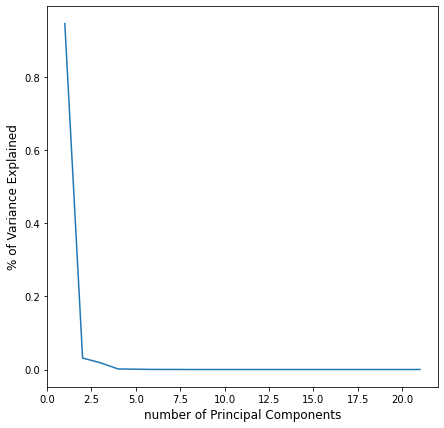

In [9]:
pca = PCA(random_state=1004)
pca.fit_transform(x_no_genre)


## percentage of variance explained
print(pca.explained_variance_ratio_)
# [0.92461872 0.05306648 0.01710261 0.00521218]


## Principal 1 & 2 explain about 97.8% of variance
plt.rcParams['figure.figsize'] = (7, 7)
plt.plot(range(1, x_no_genre.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel("number of Principal Components", fontsize=12)
plt.ylabel("% of Variance Explained", fontsize=12)
plt.show()

In [10]:
pca = PCA(n_components=4, random_state=1004)
x_pca = pca.fit_transform(x_no_genre)

In [11]:
x_pca=pd.DataFrame(x_pca)

In [12]:
x_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46252 entries, 0 to 46251
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       46252 non-null  float64
 1   1       46252 non-null  float64
 2   2       46252 non-null  float64
 3   3       46252 non-null  float64
dtypes: float64(4)
memory usage: 1.4 MB


In [14]:
len(y_true)

46252

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    x_no_genre,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)


In [16]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_pca = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_pca.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000building tree 10 of 1000

building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000building tree 14 of 1000
building tree 15 of 1000

building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000building tree 28 of 1000building tree 29 of 1000


building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000building tree 34 of 1000building tree 35 of 1000building tree 36 of 1000



building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000building tree 40 of 1000

building 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s



building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000building tree 61 of 1000

building tree 62 of 1000building tree 63 of 1000

building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000building tree 70 of 1000

building tree 71 of 1000building tree 72 of 1000

building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s



building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000building tree 176 of 1000

building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000building tree 180 of 1000

building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000building tree 197 of 1000

building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000building tree 202 of 1000

building tree 203 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.6s



building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000building tree 366 of 1000

building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000building tree 371 of 1000

building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    4.9s


building tree 644 of 1000

building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000building tree 673 of 1000

building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.8s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=1234,
                                                    verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [17]:
rf_pca.best_score_

0.637225864291531